In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mmohaiminulislam/vehicles-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ivand\.cache\kagglehub\datasets\mmohaiminulislam\vehicles-image-dataset\versions\1


In [8]:
# Import necessary libraries
import os
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

Dataset found.
Train and validation dataloaders created.
Class distribution: {'airplane': 133, 'ambulance': 153, 'bicycle': 151, 'boat': 171, 'bus': 165, 'car': 166, 'fire_truck': 174, 'helicopter': 172, 'hovercraft': 178, 'jet_ski': 167, 'kayak': 169, 'motorcycle': 174, 'rickshaw': 163, 'scooter': 150, 'segway': 159, 'skateboard': 156, 'tractor': 159, 'truck': 148, 'unicycle': 149, 'van': 169}


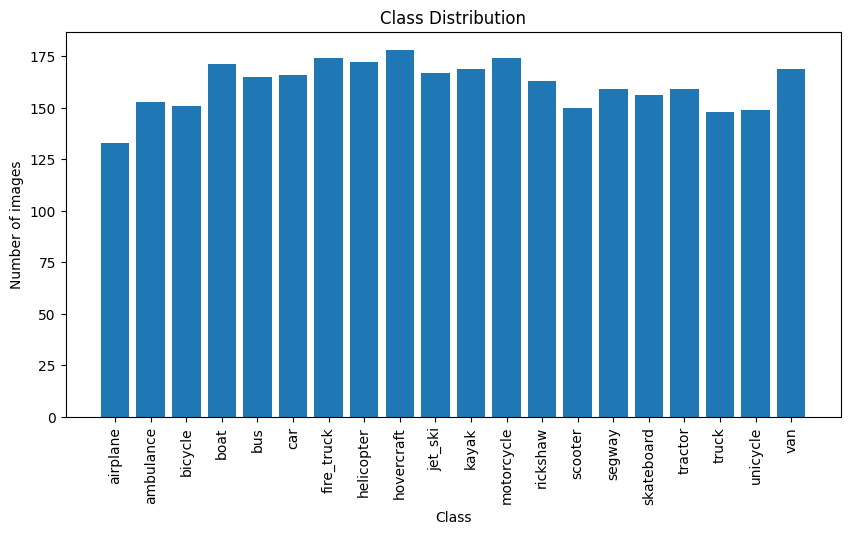

In [ ]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # Obtener todas las imágenes en el directorio
        self.paths = [path for path in sorted(glob(f"{root}/*/*jpg"))]
        self.class_names = {}
        self.class_counts = {}
        self.class_to_idx = {}
        self.idx_to_class = {}  

        class_names = sorted({os.path.normpath(path).split(os.sep)[-2] for path in self.paths})
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
        self.idx_to_class = {i: cls_name for i, cls_name in enumerate(class_names)}

        for path in self.paths:
            class_name = os.path.normpath(path).split(os.sep)[-2]  # Obtener el nombre de la clase del directorio
            # Asignar un índice a cada clase
            if class_name not in self.class_counts:
                self.class_counts[class_name] = 1 # Inicializar el conteo de la clase
            else:
                self.class_counts[class_name] += 1 # Incrementar el conteo de la clase
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        image = Image.open(path).convert("RGB")
        # Obtener la clase de la imagen
        class_names = path.split(os.sep)[-2]  # Obtener el nombre de la clase del directorio
        label = self.class_names[class_names]  # Obtener el índice de la clase
        # Cargar la imagen y aplicar transformaciones
        if self.transforms:
            image = self.transforms(image)
        return image, label
    
    def get_class_distribution(self):
        return self.class_counts

    
def get_dataloader(root, batch_size=32, num_workers=4, val_split=0.2):
    # Definir las transformaciones para el dataset
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Crear el dataset y los dataloaders
    full_dataset = CustomDataset(root=root, transforms=train_transform)
    
    val_size = int(val_split * len(full_dataset))
    train_size = len(full_dataset) - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    
    # Aplicar transformaciones 
    train_dataset.dataset.transforms = train_transform
    val_dataset.dataset.transforms = val_transform

    # Crear los dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, full_dataset.idx_to_class

path = path + "\\vehicle_data"
if path is not None:
    # Check if the dataset is downloaded
    if not os.path.exists(path):
        print("Dataset not found. Please check the path.")
    else:
        print("Dataset found.")

# Get the dataloaders   
train_loader, val_loader, idx_to_class = get_dataloader(path, batch_size=32, num_workers=4, val_split=0.2)
print("Train and validation dataloaders created.")
# Check the class distribution
dataset = CustomDataset(root=path)
class_distribution = dataset.get_class_distribution()
print("Class distribution:", class_distribution)
# Visualize the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()



In [10]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

In [ ]:
class NeuralNetwork(nn.Module): 
    def __init__(self):
        '''
        Construcción de la Red, define las capas que se utiizaran.
        '''
        super(NeuralNetwork, self).__init__()
        
        #Toma en cuenta el constructor de las capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)

        self.fc1 = nn.Linear(32 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)

    def forward(self, x):
        '''
        Define el orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 32 * 5 * 5)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x 
    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''
        Define una función de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza también el caso 
        en que se llegue a utilizar cuda. Muestra una gráfica al finalizar el
        entrenamiento usando el lost obtenido.
        ''' 
        losses = []

        if(cuda and torch.cuda.is_available()): 
            self.cuda()

        for epoch in range(epochs): 
            running_loss = 0.0

            for i, data in enumerate(data_loader, 0): 
                inputs, labels = data 

                if(cuda and torch.cuda.is_available()): 
                    inputs = inputs.cuda()
                    labels = labels.cuda() 

                optimizer.zero_grad() 
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward() 
                optimizer.step() 
                running_loss += loss.item()

            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print('Epoch %d, loss: %.6f' % (epoch + 1, epoch_loss))
            
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Perdida durante el entrenamiento')
        plt.show()



RedNeuronal = NeuralNetwork()

criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(RedNeuronal.parameters(), lr=0.0001)

RedNeuronal.train(50,train_loader,criterio,optimizer,cuda=False)

prec_train =calcularPrecisionGlobal(RedNeuronal,train_loader,4)
prec_val   =calcularPrecisionGlobal(RedNeuronal,val_loader,4)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

In [ ]:
import numpy as np 
def predict(model, image, cuda = False): 
    if(cuda and torch.cuda.is_available()):
        image = image.cuda()

    if isinstance(image, torch.Tensor):
        npimg = image.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
    else:
        npimg = image.numpy()

    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

    if not isinstance(image, torch.Tensor): 
        transform = transforms.Compose([
            transforms.toTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        image = transform(image)

    image = image.unsqueeze(0)

    with torch.no_grad(): 
        output = model(image)
        prob = F.softmax(output, dim=1)
        confidence, predicted = torch.max(prob, 1)
        confidence = confidence.item()
        predicted = predicted.item()

    print(f"Predicción: {labels[predicted]} (Confianza: {confidence*100:.2f}%)")
    return predicted, confidence

dataiter = iter(val_loader)
images, labels = dataiter.__next__()

for i in range(10): 
    predict(NeuralNetwork, images[i], cuda=False)
    print('Etiqueta real: %s' % labels[labels[i]])




In [ ]:
#Matriz de confusión	
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, data_loader, class_names, cuda=False):
    all_labels = []
    all_preds = []

    if(cuda and torch.cuda.is_available()): 
        model.cuda()

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            if(cuda and torch.cuda.is_available()): 
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names)

# Initialize the model
model = NeuralNetwork()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Train the model
model.train(epochs=5, data_loader=train_loader, criterion=criterion, optimizer=optimizer, cuda=False)
# Evaluate the model
evaluate_model(model, val_loader, class_names, cuda=False)
# Save the model
torch.save(model.state_dict(), 'vehicle_model.pth')


In [ ]:
# Load the model
model = NeuralNetwork()
model.load_state_dict(torch.load('vehicle_model.pth'))
# Evaluate the model
evaluate_model(model, val_loader, class_names, cuda=False)
# Predict on a single image
image, label = val_loader.dataset[0]
predict(model, image, cuda=False)
# Save the model
torch.save(model.state_dict(), 'vehicle_model.pth')
